# Neural network Classifier x Toxic Content Detection
Il presente Notebook mostra l'addestramento ed il testing di un Classificatore basato su Neural network per il task di Toxic Content Detection.

I dati sono stati processati come segue:
1. Pulizia del testo (si veda, 'dataset_preprocessing.py')
2. Lemmatizzazione con NLTK
3. Vettorizzazione con TF-IDF

In [1]:
import pandas as pd
import pickle
import nltk
import re
import seaborn as sns
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense,Reshape
from tensorflow.keras.optimizers.legacy import Adam as Adam_legacy
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

/var/folders/ss/s59pk8px01vb8p_b48z9wxz40000gn/T/ipykernel_19149/3259976506.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Neural Network, Dataset "non-Lemmatizzato"

In [2]:
training_set = pd.read_csv("./../../datasets/training_set.csv")
test_data = pd.read_csv("./../../datasets/test_set.csv")
test_data.dropna(inplace=True)
test_set = test_data[test_data['toxic']!=-1]
# Osservazione: il Training Set è stato già ripulito

In [3]:
# Vettorizzazione con TF-IDF
vectorizer = TfidfVectorizer()
vectorizer_lem = TfidfVectorizer()

y_train = training_set['toxic']
X_train = vectorizer.fit_transform(training_set['comment_text'])

print("y_train.shape: " + str(y_train.shape))
print("X_train.shape: " + str(X_train.shape))


y_train.shape: (15282,)
X_train.shape: (15282, 39767)


## Addestramento del Modello

In [4]:
#Verifica presenza della GPU
import tensorflow as tf

# Verifica il dispositivo attualmente utilizzato da TensorFlow
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
    print('GPU disponibile, TensorFlow sta utilizzando la GPU.')
else:
    print('GPU non disponibile, TensorFlow sta utilizzando la CPU.')


GPU disponibile, TensorFlow sta utilizzando la GPU.


2024-02-10 19:29:01.735640: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-02-10 19:29:01.735668: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-02-10 19:29:01.735673: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-02-10 19:29:01.735724: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-10 19:29:01.735743: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
X_train = X_train.toarray()
X_train.shape

(15282, 39767)

In [6]:
model_filename = 'nn_classifier.pkl'
model = None

In [7]:
#CNN model
review = Input(shape=(X_train.shape[1],), dtype='float', name='review')
# Aggiunta di una dimensione per rappresentare il canale (l'input è bidimensionale e ci aspetta invece la dimensione associata al canale)
review_reshaped = Reshape((X_train.shape[1], 1))(review)
    
# Layer convoluzionali
conv_1 = Conv1D(filters=32, kernel_size=5, activation='relu')(review_reshaped)
max_pool_1 = MaxPooling1D(pool_size=2)(conv_1)
conv_2 = Conv1D(filters=32, kernel_size=3, activation='relu')(max_pool_1)
max_pool_2 = MaxPooling1D(pool_size=2)(conv_2)
conv_3 = Conv1D(filters=64, kernel_size=5, activation='relu')(max_pool_2)

# Appiattimento e strato fully-connected
flatten = Flatten()(conv_3)
main_output = Dense(1, activation='sigmoid', name='main_output')(flatten)

# Costruzione del modello
model = Model(inputs=[review], outputs=[main_output])
    
# Compilazione del modello
optimizer = Adam_legacy(learning_rate=1e-2)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

2024-02-10 19:29:06.578871: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-10 19:29:06.578897: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 review (InputLayer)         [(None, 39767)]           0         
                                                                 
 reshape (Reshape)           (None, 39767, 1)          0         
                                                                 
 conv1d (Conv1D)             (None, 39763, 32)         192       
                                                                 
 max_pooling1d (MaxPooling1  (None, 19881, 32)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 19879, 32)         3104      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 9939, 32)          0         
 g1D)                                                        

In [44]:
# OLD CNN Model
'''
model = tf.keras.models.Sequential([
tf.keras.layers.Reshape((39767, 1), input_shape=(39767,)),  
tf.keras.layers.Conv1D(filters=25, kernel_size=11, strides=4,
activation='relu',input_shape=(39767, 1)),
tf.keras.layers.MaxPool1D(pool_size=3, strides=2,padding='same'),
tf.keras.layers.Conv1D(filters=65, kernel_size=5, padding='same',
activation='relu'),
tf.keras.layers.MaxPool1D(pool_size=3, strides=2,padding='same'),
tf.keras.layers.Conv1D(filters=70, kernel_size=3, padding='same',
activation='relu'),
tf.keras.layers.Conv1D(filters=60, kernel_size=1, padding='same',
activation='relu'),
tf.keras.layers.Dense(155, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(40, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1,activation='sigmoid')
])
'''

In [11]:
model.fit(X_train, y_train,epochs=5, batch_size=34)

Epoch 1/5
450/450 [==============================] - 93s 199ms/step - loss: 0.6299 - accuracy: 0.8221
Epoch 2/5
450/450 [==============================] - 87s 194ms/step - loss: 0.2436 - accuracy: 0.9090
Epoch 3/5
450/450 [==============================] - 87s 194ms/step - loss: 0.1156 - accuracy: 0.9589
Epoch 4/5
450/450 [==============================] - 87s 194ms/step - loss: 0.0479 - accuracy: 0.9852
Epoch 5/5
450/450 [==============================] - 88s 195ms/step - loss: 0.0344 - accuracy: 0.9887


In [12]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 review (InputLayer)         [(None, 39767)]           0         
                                                                 
 reshape_1 (Reshape)         (None, 39767, 1)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 39763, 32)         192       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 19881, 32)         0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 19879, 32)         3104      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 9939, 32)          0         
 g1D)                                                      

In [35]:
model.variables

[<tf.Variable 'conv1d_2/kernel:0' shape=(5, 1, 32) dtype=float32, numpy=
 array([[[ 2.01237106e+00,  1.86899662e+00,  5.24043679e-01,
           1.43309820e+00,  2.06527129e-01,  1.54839778e+00,
          -1.70115694e-01,  2.31218696e+00, -3.27331215e-01,
           1.35403359e+00,  3.54670882e-02,  9.33951616e-01,
          -1.14711918e-01,  1.10249507e+00, -2.10701451e-01,
           1.15359354e+00,  8.10476899e-01, -1.59173548e-01,
           3.66490595e-02, -6.15192838e-02,  1.23988226e-01,
          -3.54887098e-01,  6.04607575e-02,  5.74934483e-02,
          -1.03489041e+00, -2.78329372e-01, -5.60478598e-04,
           5.84471412e-02, -3.67589265e-01,  1.06097901e+00,
           1.57313347e+00, -2.24515617e-01]],
 
        [[ 2.41568491e-01, -1.95778057e-01, -4.72457223e-02,
           4.13412958e-01, -1.65004551e-01,  1.29614413e+00,
           1.32364392e+00, -2.74627626e-01, -1.60185480e+00,
          -9.53935742e-01,  2.95206048e-02, -2.69089907e-01,
          -9.96192321e-02

In [13]:
print(model!=None)

True


In [15]:
with open(model_filename, 'wb') as f:
    pickle.dump(model, f)

In [8]:
with open(model_filename, 'rb') as f:
    model = pickle.load(f)

# Testing del Sistema, Dataset "Non Lemmatizzato"

In [9]:
test_data = pd.read_csv("./../../datasets/test_set.csv")
test_data.dropna(inplace=True)
test_set = test_data[test_data['toxic'] != -1]
X_test = vectorizer.transform(test_set['comment_text'])
print(X_test.shape)



(63842, 39767)


In [10]:
print(str(X_test.shape))

(63842, 39767)


In [11]:
X_test = X_test.toarray()

In [12]:
X_test1 = X_test[20000:40000]

In [13]:
X_test2 = X_test[:20000]

In [14]:
X_test3 = X_test[40000:]

In [15]:
if np.any(X_test):
    print("X_test contiene elementi diversi da 0")
else:
    print("X_test contiene solo zeri")

X_test contiene elementi diversi da 0


In [16]:
y_test = test_set['toxic']
print("y_test.shape: " + str(y_test.shape))

y_test.shape: (63842,)


In [25]:
y_test_sampled2 = y_test[20000:40000]

In [26]:
print("y_test.shape: " + str(y_test_sampled1.shape))

y_test.shape: (20000,)


In [36]:
 # Ora puoi fare le predizioni
y_pred = model.predict(X_test) # Le predizioni saranno di dimensioni (63842, 1)


: 

In [28]:
tot = 500  # Imposta il numero di elementi da stampare prima di saltare

for i in range(0, 20000, tot):
    print(y_pred[i])

[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]
[0.3319607]


In [32]:

print(y_pred)

[[0.3319607]
 [0.3319607]
 [0.3319607]
 ...
 [0.3319607]
 [0.3319607]
 [0.3319607]]


In [34]:
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

#Metriche: Accuracy,Precision,Recall
print("Accuracy: " + str(accuracy_score(y_test_sampled2, y_pred_binary)))
print("Precision: " + str(precision_score(y_test_sampled2, y_pred_binary)))
print("Recall: " + str(recall_score(y_test_sampled2, y_pred_binary)))

Accuracy: 0.9045
Precision: 0.0
Recall: 0.0


/Users/alessandropesare/anaconda3/envs/DL_GPU_Full/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


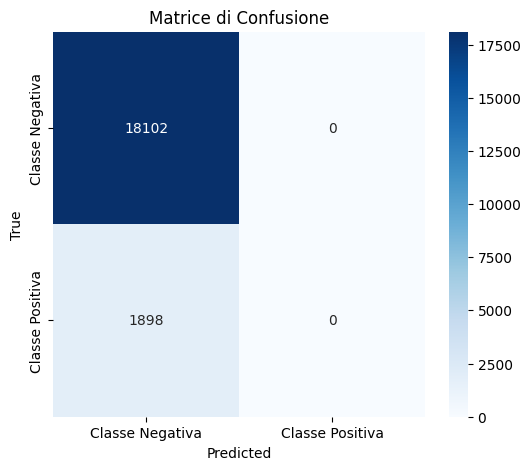

In [34]:
conf_matrix = confusion_matrix(y_test_sampled, y_pred_binary)

# Definisci le etichette delle classi
classes = ['Classe Negativa', 'Classe Positiva']

# Plotta la matrice di confusione
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matrice di Confusione')
plt.show()

# Neural Network, Dataset "Lemmatizzato"

In [ ]:
training_set_lem = pd.read_csv("./../../datasets/training_set_lemmatized.csv")
test_data_lem = pd.read_csv("./../../datasets/test_set_lemmatized.csv")
test_set_lem = test_data[test_data['toxic']!=-1]
test_data_lem.dropna(inplace=True)

In [ ]:
# Vettorizzazione con TF-IDF
vectorizer = TfidfVectorizer()
vectorizer_lem = TfidfVectorizer()

y_train = training_set['toxic']
X_train_lem = vectorizer_lem.fit_transform(training_set_lem['comment_text'])
X_test_lem = vectorizer_lem.transform(test_set_lem['comment_text'])

print("y_train.shape: " + str(y_train.shape))
print("X_train_lem.shape: " + str(X_train_lem.shape))
print("X_test_lem.shape: " + str(X_test_lem.shape))


## Addestramento del Modello

In [ ]:
#Verifica presenza della GPU
import tensorflow as tf

# Verifica il dispositivo attualmente utilizzato da TensorFlow
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
    print('GPU disponibile, TensorFlow sta utilizzando la GPU.')
else:
    print('GPU non disponibile, TensorFlow sta utilizzando la CPU.')

In [ ]:
X_train_lem = X_train_lem.toarray()

In [ ]:
# Building the CNN Model

model = tf.keras.models.Sequential([
tf.keras.layers.Reshape((34238, 1), input_shape=(34238,)),  
tf.keras.layers.Conv1D(filters=96, kernel_size=11, strides=4,
activation='relu',input_shape=(39767, 1)),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Conv1D(filters=120, kernel_size=5, padding='same',
activation='relu'),
tf.keras.layers.Conv1D(filters=240, kernel_size=3, padding='same',
activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Conv1D(filters=300, kernel_size=3, padding='same',
activation='relu'),
tf.keras.layers.Conv1D(filters=150, kernel_size=1, padding='same',
activation='relu'),
tf.keras.layers.MaxPool1D(pool_size=3, strides=2,padding='same'),
tf.keras.layers.Dense(80, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(40, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1,activation='sigmoid')
])

In [ ]:
model.build()
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

In [ ]:
model.fit(X_train_lem, y_train, epochs=10, batch_size=32)

In [ ]:
with open(model_filename, 'wb') as f:
    pickle.dump(model, f)

In [ ]:
with open(model_filename, 'rb') as f:
    model = pickle.load(f)

# Testing del Sistema, Dataset "Non Lemmatizzato"